#   Data cleaning

In [162]:
# we'll import pandas for the data cleaning
import pandas as pd

In [291]:
# read the different csv files
training_data = pd.read_csv('./Locaria -Data/training_data.csv')
dimensions = pd.read_csv('./Locaria -Data/dimensions.csv')
exchange_rates = pd.read_csv('./Locaria -Data/exchange_rates.csv')

In [292]:
# convert all prices to GBP
exchangeToGBP = exchange_rates[exchange_rates.to_currency == 'GBP']
training_data['priceInGBP'] = [x if y == 'GBP' else x*exchangeToGBP[exchangeToGBP['from_currency'] == y]['rate'].values[0] for (x,y) in zip(training_data['Price'], training_data['currency'])]

In [293]:
# dummies from the metrics in dimensions
dummies = pd.get_dummies(dimensions['variable']).mul(dimensions.value,0)
dimensions = pd.concat([dimensions, dummies], axis=1)

In [294]:
# join dimensions to training set
training_data = training_data.join(dimensions[dimensions.x != 0][['ID', 'x']].set_index('ID'), on='ID')
training_data = training_data.join(dimensions[dimensions.y != 0][['ID', 'y']].set_index('ID'), on='ID')
training_data = training_data.join(dimensions[dimensions.z != 0][['ID', 'z']].set_index('ID'), on='ID')

And so training_data, which will be split into train and test (validation in fact) ends up like this, before feature engineering on x4 and currency and also without standarizing it:

In [295]:
training_data

,Price,x2,x3,x4,x5,x6,ID,currency,priceInGBP,x,y,z
0,1826.796510,0.37,71,IF,62.1,54.0,5,AUD,1056.0,1.411250e+09,1.423568e+09,8.808127e+08
1,4357.670841,0.73,68,SI2,62.4,58.0,8,AUD,2519.0,1.754858e+09,1.739575e+09,1.092576e+09
2,2112.233465,0.42,70,VVS2,61.3,57.0,10,AUD,1221.0,1.478744e+09,1.472656e+09,9.053650e+08
3,728.296715,0.30,72,SI1,59.3,59.0,46,AUD,421.0,1.337619e+09,1.343799e+09,7.948798e+08
4,5546.126525,0.75,69,VS2,62.8,55.0,81,AUD,3206.0,1.770198e+09,1.776392e+09,1.114059e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
38265,5927.346129,1.00,69,SI2,60.6,61.0,53926,USD,4390.0,1.975749e+09,1.960474e+09,1.193854e+09
38266,1101.757276,0.31,71,VVS1,60.2,59.0,53930,USD,816.0,1.343755e+09,1.359139e+09,8.132940e+08
38267,13527.581062,1.01,70,VVS1,62.9,57.0,53933,USD,10019.0,1.948138e+09,1.966610e+09,1.230683e+09
38268,4166.694796,0.84,69,SI2,59.2,59.0,53935,USD,3086.0,1.899051e+09,1.883773e+09,1.120197e+09


# Exploratory Analysis

In [296]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38270 entries, 0 to 38269
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       38270 non-null  float64
 1   x2          38270 non-null  float64
 2   x3          38270 non-null  int64  
 3   x4          38270 non-null  object 
 4   x5          38270 non-null  float64
 5   x6          38270 non-null  float64
 6   ID          38270 non-null  int64  
 7   currency    38270 non-null  object 
 8   priceInGBP  38270 non-null  float64
 9   x           38265 non-null  float64
 10  y           38266 non-null  float64
 11  z           38256 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 3.5+ MB


There are only 4 types of currencies, there are 8 categories in x4 and 7 possible values for x3:

In [297]:
training_data.nunique()

Price         17553
x2              262
x3                7
x4                8
x5              174
x6              120
ID            38270
currency          4
priceInGBP    16921
x               536
y               535
z               356
dtype: int64

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x3'}>],
       [<AxesSubplot:title={'center':'x5'}>,
        <AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'ID'}>],
       [<AxesSubplot:title={'center':'priceInGBP'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

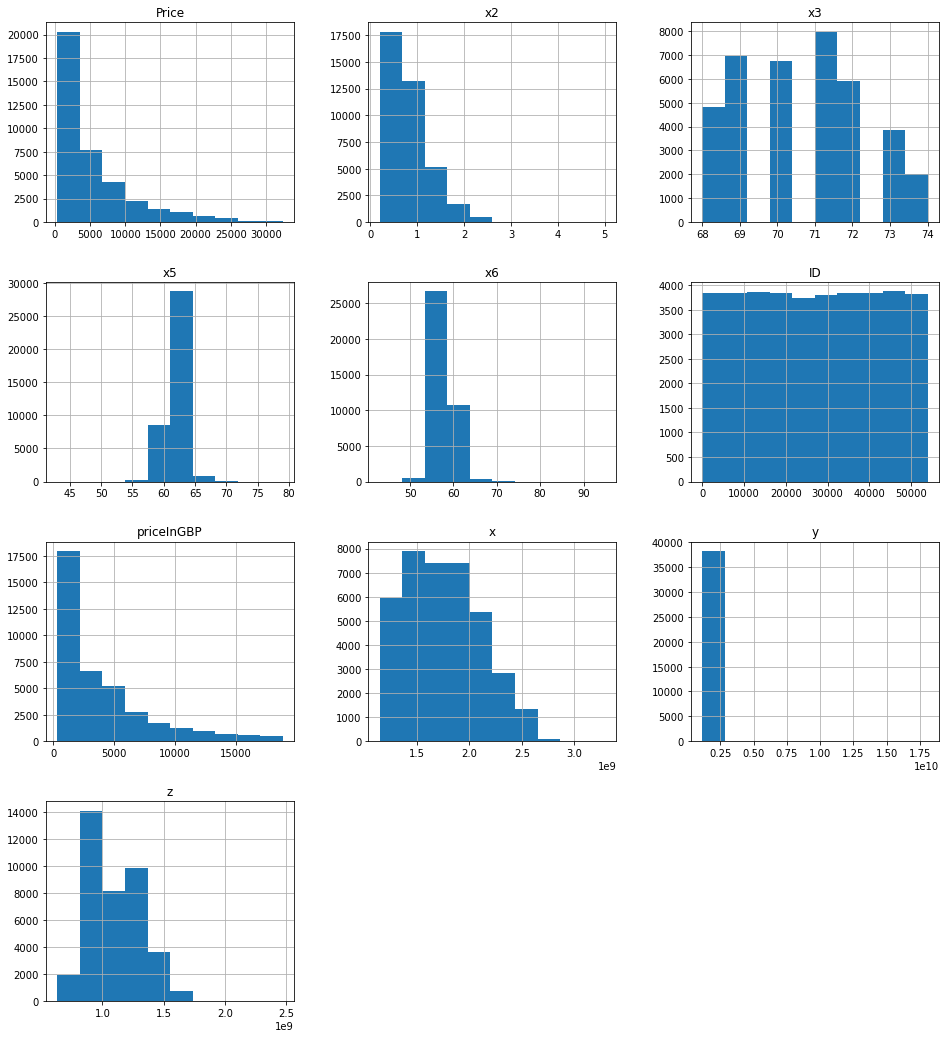

In [298]:
training_data.hist(figsize=(16,18))

If we OHE on x4, we can see that some categories, such as l1 and IF, do not have much representation:

array([[<AxesSubplot:title={'center':'x4_I1'}>,
        <AxesSubplot:title={'center':'x4_IF'}>,
        <AxesSubplot:title={'center':'x4_SI1'}>],
       [<AxesSubplot:title={'center':'x4_SI2'}>,
        <AxesSubplot:title={'center':'x4_VS1'}>,
        <AxesSubplot:title={'center':'x4_VS2'}>],
       [<AxesSubplot:title={'center':'x4_VVS1'}>,
        <AxesSubplot:title={'center':'x4_VVS2'}>, <AxesSubplot:>]],
      dtype=object)

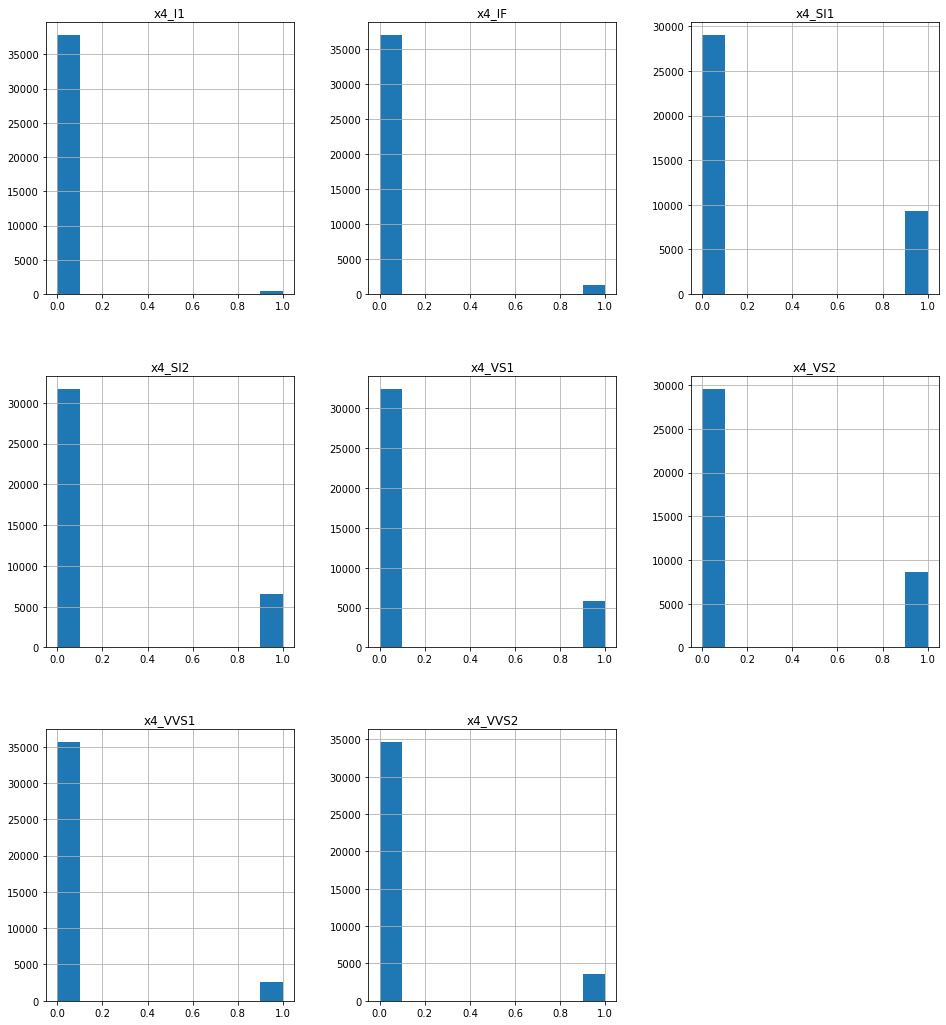

In [240]:
# one-hot encoding of x4
OHE_x4 = pd.get_dummies(training_data.x4, prefix='x4')
OHE_x4.hist(figsize=(16,18))

It is possible that Target Encoding them does help, but further data augmentation techniques could be applied. Below the correlation matrix between the non-categorical variables is shown. We can see how x, y and z are highly correlated between them and also how x2 is highly correlated to them:

<AxesSubplot:>

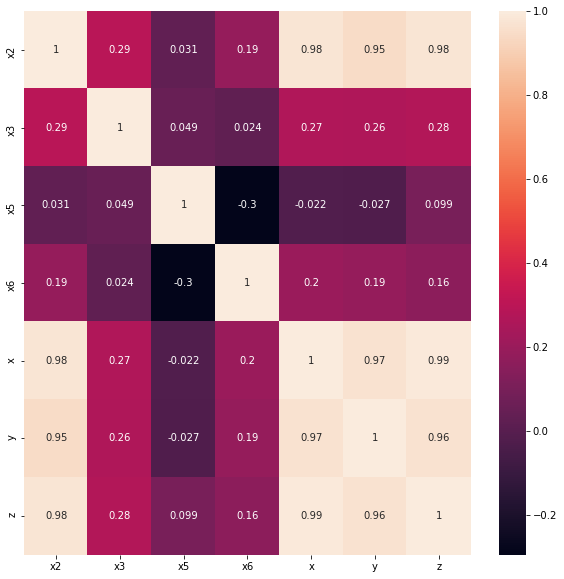

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(training_data.corr(), annot=True, ax=ax)

# Prediction

In [277]:
#import MAPE from sklearn, lightgbm and train_test_split function
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [278]:
# define target and split data into train and test
y = training_data['priceInGBP']
training_data = training_data.drop(columns=['Price', 'priceInGBP', 'ID'])
x_train, x_test, y_train, y_test = train_test_split(training_data, y, test_size=0.2)

In [279]:
# target mean encoding of x4
TE_x4 = {cat:y_train[x_train.index[x_train.x4 == cat].to_list()].mean() for cat in x_train.x4.unique()}
x_train['x4'] = x_train['x4'].map(TE_x4)
x_test['x4'] = x_test['x4'].map(TE_x4)

# target mean encoding of currency
TE_currency = {cat:y_train[x_train.index[x_train.currency == cat].to_list()].mean() for cat in x_train.currency.unique()}
x_train['currency'] = x_train['currency'].map(TE_currency)
x_test['currency'] = x_test['currency'].map(TE_currency)

# standarize X
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

<ipython-input-279-5a3a327bb079>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['x4'] = x_train['x4'].map(TE_x4)
<ipython-input-279-5a3a327bb079>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['x4'] = x_test['x4'].map(TE_x4)
<ipython-input-279-5a3a327bb079>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [280]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'learnnig_rage': 0.05,
    'metric': {'mape'},
    'verbose': -1,
}

In [281]:
# loading data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [282]:
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=50)

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's mape: 1.68929
Training until validation scores don't improve for 50 rounds
[2]	valid_0's mape: 1.52668
[3]	valid_0's mape: 1.3801
[4]	valid_0's mape: 1.24903
[5]	valid_0's mape: 1.13122
[6]	valid_0's mape: 1.02522
[7]	valid_0's mape: 0.929763
[8]	valid_0's mape: 0.844964
[9]	valid_0's mape: 0.76838
[10]	valid_0's mape: 0.698743
[11]	valid_0's mape: 0.635869
[12]	valid_0's mape: 0.580156
[13]	valid_0's mape: 0.529711
[14]	valid_0's mape: 0.484876
[15]	valid_0's mape: 0.443544
[16]	valid_0's mape: 0.40639
[17]	valid_0's mape: 0.37299
[18]	valid_0's mape: 0.343002
[19]	valid_0's mape: 0.316151
[20]	valid_0's mape: 0.292258
[21]	valid_0's mape: 0.270931
[22]	valid_0's mape: 0.250924
[23]	valid_0's mape: 0.233791
[24]	valid_0's mape: 0.218071
[25]	valid_0's mape: 0.204815
[26]	valid_0's mape: 0.192704
[27]	valid_0's mape: 0.182314
[28]	valid_0's mape: 0.172428
[29]	valid_0's mape: 0.163068
[30]	valid_0's mape: 0.155502
[31]	valid_0's mape: 0.148951
[32]	valid_0's mape: 0.14274

Best so far is a MAPE of 0.0843234. Let's see if we can do better throughout a randomized cv search. It is collapsed due to the output being too large, but can be ran in approximately 3 to 5 minutes:

In [225]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
rs_params = {

        'bagging_fraction': np.linspace(0.5, 0.8, num=3),
        'bagging_frequency': np.linspace(5, 8, num=4),
        'feature_fraction': np.linspace(0.5, 0.8, num=4),
        'max_depth': np.arange(10, 21, 1),
        'min_data_in_leaf': np.arange(90, 160, 10),
        'num_leaves': np.arange(1200, 2500, 100)

}

# Initialize a RandomizedSearchCV object using 5-fold CV
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params, cv = 5, n_iter=100, verbose=1)

# Train on training data
rs_cv.fit(x_train, y_train, verbose=0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'bagging_fraction': array([0.5 , 0.65, 0.8 ]),
                                        'bagging_frequency': array([5., 6., 7., 8.]),
                                        'feature_fraction': array([0.5, 0.6, 0.7, 0.8]),
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                                        'min_data_in_leaf': array([ 90, 100, 110, 120, 130, 140, 150]),
                                        'num_leaves': array([1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400])},
                   verbose=1)

Print out the best working parameters:

In [226]:
rs_cv.best_params_

{'num_leaves': 1600,
 'min_data_in_leaf': 90,
 'max_depth': 20,
 'feature_fraction': 0.8,
 'bagging_frequency': 7.0,
 'bagging_fraction': 0.65}

Add them to baseline parameters and re-train and validate model:

In [283]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'learnnig_rage': 0.05,
    'metric': {'mape'},
    'verbose': -1,
    'num_leaves': 1600,
    'min_data_in_leaf': 90,
    'max_depth': 20,
    'feature_fraction': 0.8,
    'bagging_frequency': 7,
    'bagging_fraction': 0.65}

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round = 500,
                 early_stopping_rounds=300)

[1]	valid_0's mape: 1.68635
Training until validation scores don't improve for 300 rounds
[2]	valid_0's mape: 1.51974
[3]	valid_0's mape: 1.37029
[4]	valid_0's mape: 1.23549
[5]	valid_0's mape: 1.11428
[6]	valid_0's mape: 1.00554
[7]	valid_0's mape: 0.907868
[8]	valid_0's mape: 0.820636
[9]	valid_0's mape: 0.741542
[10]	valid_0's mape: 0.670586
[11]	valid_0's mape: 0.606881
[12]	valid_0's mape: 0.549769
[13]	valid_0's mape: 0.499057
[14]	valid_0's mape: 0.453624
[15]	valid_0's mape: 0.412978
[16]	valid_0's mape: 0.375751
[17]	valid_0's mape: 0.342345
[18]	valid_0's mape: 0.31251
[19]	valid_0's mape: 0.286253
[20]	valid_0's mape: 0.262761
[21]	valid_0's mape: 0.241197
[22]	valid_0's mape: 0.222142
[23]	valid_0's mape: 0.204783
[24]	valid_0's mape: 0.189943
[25]	valid_0's mape: 0.175971
[26]	valid_0's mape: 0.163605
[27]	valid_0's mape: 0.152478
[28]	valid_0's mape: 0.142778
[29]	valid_0's mape: 0.134003
[30]	valid_0's mape: 0.126434
[31]	valid_0's mape: 0.119551
[32]	valid_0's mape: 0.1

Best MAPE achieved was of 0.0689503. Could be optimized further but so far a MAPE of less than 10% can be considered a pretty good result during validation. We'll see during test!

# Test set submission file

In [284]:
test_data = pd.read_csv('./Locaria -Data/test_data.csv')

Add dimensions data:

In [285]:
# join dimensions to test set
test_data = test_data.join(dimensions[dimensions.x != 0][['ID', 'x']].set_index('ID'), on='ID')
test_data = test_data.join(dimensions[dimensions.y != 0][['ID', 'y']].set_index('ID'), on='ID')
test_data = test_data.join(dimensions[dimensions.z != 0][['ID', 'z']].set_index('ID'), on='ID')

Target encoding through the mapping produced with training set (x_train):

In [286]:
# target mean encoding of x4
test_data['x4'] = test_data['x4'].map(TE_x4)

# target mean encoding of currency
test_data['currency'] = test_data['currency'].map(TE_currency)

Prepare the data for the model:

In [287]:
ID = test_data['ID'] 
# drop price, ID
test_data = test_data.drop(columns=['Price', 'ID'])

# standarize X
x_test = sc.transform(test_data)

In [288]:
# predict through the model
y_pred = model.predict(x_test)

In [289]:
# store into submission file
results = pd.DataFrame({'ID':ID, 'predicted_price': y_pred})
results.to_csv('submission.csv')